In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = "/home/clairegayral/Documents/openclassroom/data/"
res_path = "/home/clairegayral/Documents/openclassroom/src/P2_gayral_claire/res/"

## my .py : 
import read_csv
import preprocess
import list_from_data_field 
import missing_values_treatment

My preprocess consisted in :
* Read the data : I only kept data with the "nutrition score" for this analyse,
* Drop the columns with too many missing values
* Select the variables that will interest me : the nutrition variable, with name of the product, its code reference, country of sell, and name of the person that inter it in the open food fact base.
* Merge the two columns that are about the palm oil ingredients.
* Remove outliers (from the semantic of columns, and compared to the other float values with hierarchical clustering)

**Mon prétraitement consistait en :**
* Lecture des données : Je n'ai gardé que les données avec le "score nutritionnel" pour cette analyse,
* Suppression des colonnes avec trop de valeurs manquantes
* Sélection des variables d'intérêt : la variable nutritionnelle, avec le nom du produit, sa référence de code, le pays de vente, et le nom de la personne qui l'a introduit dans la base de données 'open food facts'.
* Fusion des deux colonnes qui concernent les ingrédients de l'huile de palme.
* Fusion des doublons (par nom de produit)
* Suppression les valeurs aberrantes (de la sémantique des colonnes, et par rapport aux autres valeurs avec une classification hierarchique).


In [2]:
##
## read data : 
##
# read_csv.save_csv()
df_original = pd.read_csv(data_path+"projet2/df_original.csv", 
                          low_memory=False, index_col=0)

df = df_original.copy()
print("There are ", df.shape[0],
      " products and ", df.shape[1],"variables")

There are  646576  products and  184 variables


In [3]:
##
## select variables 
##
list_of_nutri_facts = list_from_data_field.list_of_nutri_facts
interest_var = pd.Index(["code","product_name","creator","countries",
                         "additives_n","ingredients_from_palm_oil"])
interest_var = interest_var.append(df.columns.intersection(list_of_nutri_facts))
df = preprocess.select_columns(df, interest_var)


##
## set dtype : 
##
df = preprocess.set_dtypes(df)

##
## merge "from palm oil" 
##
df = preprocess.merge_palm_oil_cols(df)

In [4]:
##
## drop empty columns
##
nan_repartition = df_original.isna().sum(axis=0)
# nan_threshold = nan_repartition.mean()
nan_threshold = nan_repartition.quantile(0.75)
df = preprocess.preprocess_drop_col_nan(df_original, nan_threshold)

print("I droped variables with less than", 
      df.shape[0]-np.floor(nan_threshold),
      " values")
print("I have dropped", df_original.shape[1]-df.shape[1], "variables")

I droped variables with less than 60.0  values
I have dropped 46 variables


In [5]:
df.shape

(646576, 138)

To drop duplicates, I compute a hierarchical clustering on the euclidean distance matrix of products with the same name, and I saved the indexes to gather in a dictionnary : 

```python
# prod_name = "Salade de carottes râpées"
prod_name = "Abondance"
res = {}

x = data[data.product_name == prod_name]
prod_index = x.index
## if there is more than one product with the same name 
if len(prod_index) > 1 : 
    prod_values = data_float.loc[prod_index,:]
    prod_dist = pd.DataFrame(nan_euclidean_distances(prod_values),
                          columns=prod_index, index = prod_index)
    Z = linkage(prod_dist, "weighted")
    prod_clustering = pd.Series(fcluster(Z, t=1.15), index = prod_index)
    for k in np.unique(prod_clustering.values):
        index_merge = prod_clustering[prod_clustering==k].index
        res[prod_name+str(k)]= index_merge

```

In [6]:
##
## Extract float data 
##

float_var = list_from_data_field.list_of_nutri_facts
float_var += ["additives_n", "ingredients_from_palm_oil","ingredients_from_palm_oil_n"]
float_var = df.columns.intersection(float_var).values

data_columns = np.insert(float_var, 0, "product_name")
data = df[data_columns].copy()

##
## Extract duplicates to be merge
##

import pickle

# res = get_index_merge_duplicates(data, float_var, 1.15)
# with open(res_path +'index_to_merge_duplicates.pkl', 'wb') as fp:
#     pickle.dump(res, fp, pickle.HIGHEST_PROTOCOL)
with open(res_path +'index_to_merge_duplicates.pkl', 'rb') as f:
    res = pickle.load(f)
    
##
## Merge duplicates from the dict
##

# data_clean = preprocess.drop_and_merge_duplicates(data)
# data_clean.to_csv(res_path+"data_duplicate_treated.csv")
data = pd.read_csv(res_path+"data_duplicate_treated.csv", index_col=0)
data.shape

(460471, 58)

Then, I used the following function to set the possible values and remove the outliers 

**J'ai ensuite utilisé la fonction suivante pour définir les valeurs possibles et supprimer les valeurs aberrantes**

outliers products : ['Large free range British eggs' 'Dessert Au Chocolat Noir'
 'Kaurasipuli-sämpylä' 'Petits Filous, Chocolat (100g x 6 Pots)'
 'Fromage blanc au lait de brebis enrichi vit.D 5% de matière grasse'
 'Céréales fourrées' 'Petits Filous Choco'
 'St Hubert Bio demi sel sans huile de palme' 'Margina ligera'
 'Milchbrei Waldbeere' 'Nesqwik АЛФАВИТ' 'Special K The Original'
 'Medium eggs' 'Rice snaps' 'Χωριό soft' 'Cheerios Aveia Maçã e Canela'
 'Oivariini Herkku' 'Alentaja 2-teho'
 'Ingmariini Paahdettu Voi, rypsiöljy & suola' 'Oat-ly hafer deluxe'
 'Cheerios Multi - דגנים מלאים' 'Bevanda di riso arricchita' nan 'Hera'
 'Rama 100% Planzlich ohne Palmöi'
 'Margarine maitre en cuisson doux Astra' 'bebida de soya' 'Original'
 'Vache qui rit' 'Jus multivitaminé' 'Choco Shells' 'Crunch' 'Coco pops'
 'Isio 4' "Kellogg's Variety" 'Ovomaltine' 'ProActiv' 'Becel ProActiv'] 



array([  3.2       ,  16.        ,   2.8       ,   1.5       ,
         1.1       ,   4.2       ,   7.        ,   7.5       ,
         6.5       ,   2.97      ,   8.4       ,   4.        ,
         5.        ,   2.71      ,  20.        ,  10.        ,
         2.5       ,   1.6       ,   2.1       ,   5.7       ,
       160.00002665,   3.6       ,   2.7       ,   1.38333725,
         4.1667    ,   1.1000025 ,   2.5025025 ])

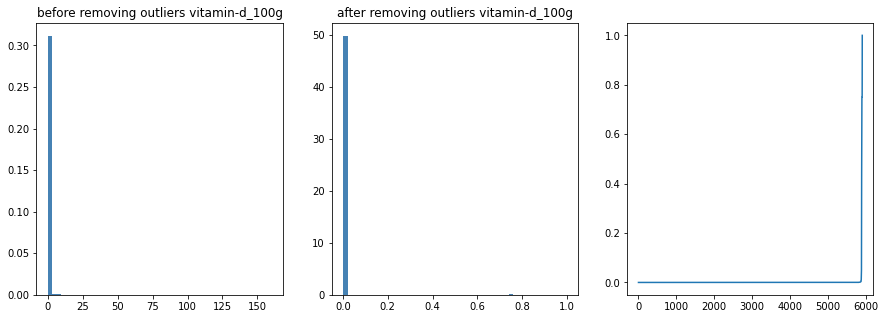

In [7]:
import missing_values_treatment
missing_values_treatment.help_to_set_outliers_vals(data, 'vitamin-d_100g', [0,1])

In [9]:
##
## from the hyp that the variable has been entered in mg instead of g -> rescale 
##
data = missing_values_treatment.rescale_outliers100g_val(data)

##
## drop outliers values and drop product/variables with too many NaNs
##
data = missing_values_treatment.drop_outliers(data)
data.shape

(53549, 34)

In [ ]:
data = df.copy()
colname = "additives_n"
possible_vals = possible_val_dict[colname]


help_to_set_outliers_vals(data, colname, possible_vals)